# 1 Setup

## 1.1 Import some great packages


In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
#progress bar
from tqdm.notebook import tqdm

## 1.2 Load the data from organizer Google drive

In [260]:
"""
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

folder_download('1g58xFQ9aDcTPetma4blzVTQYX-QKkzNf')
"""

"\ndef folder_download(folder_id):\n  # authenticate\n  from google.colab import auth\n  auth.authenticate_user()\n  # get folder_name\n  from googleapiclient.discovery import build\n  service = build('drive', 'v3')\n  folder_name = service.files().get(fileId=folder_id).execute()['name']\n  # import library and download\n  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py\n  from download import download_folder\n  download_folder(service, folder_id, './', folder_name)\n  return folder_name\n\nfolder_download('1g58xFQ9aDcTPetma4blzVTQYX-QKkzNf')\n"

In [261]:
"""
# unzip some files
!mkdir clean_las_files
! cd Data\ for\ Datathon && unzip well_log_files.zip -d /content/clean_las_files
"""

'\n# unzip some files\n!mkdir clean_las_files\n! cd Data\\ for\\ Datathon && unzip well_log_files.zip -d /content/clean_las_files\n'

In [262]:
# set paths of different subdirectories
# dir_eaglebine = 'Data for Datathon/Eaglebine/Eaglebine'
dir_eaglebine = 'Eaglebine/'
# dir_duvernay = 'Data for Datathon/Duvernay/Duvernay/'
dir_duvernay = 'Duvernay/'
# dir_dataton = 'Data for Datathon/'
dir_datathon = ''

<span style="color:blue;"> <b>
Function: Temperature gradient correction
</b> </span>

In [263]:
# Option for the temperature gradient correction
ApplyTemperatureGradient = False

from scipy import stats

def TempGradientCorrection(df_Infos):
# for a given depth, we have the entry into the corresponding True temperature data frame
# we check for up to 10 consecutive temperature measurement to compute a temperature gradient using a linear regression
# note that the true temperature measurement is normally performed every 50 ft
# the true temperature is normally higher then the BHT. In case 
#Eaglebine_Combined_cln = Eaglebine_Combined_cln.copy(deep=True)

    # input variables 
    df_Truth = df_Infos['df_Truth']
    df_Combined_cln = df_Infos['df_Combined_cln']
    BHTTemp = df_Infos['BHT Temp']
    TrueTemp = df_Infos['True Temp']
    NCTrueTemp = df_Infos['NC True Temp']
    Depth = df_Infos['Depth']
    
    x = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
    y = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]    
    
    record = -1
    # Loop on all the data frame rows
    # prefer not to use iterator because it comes from the record itself. May be an issue. 
    while (record < (len(df_Combined_cln) - 1)):
        record = record + 1  
        print(record)
    
        # check for NaN value
        FloatIndex = df_Combined_cln.iloc[record]['index in TT DF']
        # if FloatIndex.isnan() // is not supported on float64 ????
        if (FloatIndex < 600000.): 
            CurrentIndex = FloatIndex.astype('int64')
            print(CurrentIndex)
            CurrentUWI = df_Truth.iloc[CurrentIndex]['UWI']
            UWI = df_Truth.iloc[CurrentIndex]['UWI']
            print(CurrentUWI)
            y[0] = df_Truth.iloc[CurrentIndex][TrueTemp]
            x[0] = df_Truth.iloc[CurrentIndex][Depth]
            i = 1

            # loop on the maximum of ten depths on the True temperature data frame to compute thetemperature gradient
            while ((i < 10) and (UWI == CurrentUWI)):
                UWI = df_Truth.iloc[CurrentIndex - i]['UWI']
                y[i] = df_Truth.iloc[CurrentIndex - i][TrueTemp]
                print (y[i])
                x[i] = df_Truth.iloc[CurrentIndex - i][Depth]
                x[i] = x[i] - x[0]
                print (x[i])
    
                i = i + 1    

            # for the next record
            x[0] = 0.
            i = i - 1

            # Compute the linear regression coefficients
            res = stats.linregress(x, y)
            print(res.slope)
            print(res.rvalue)
            df_Combined_cln.loc[record, ['Slope']] = res.slope
            df_Combined_cln.loc[record, ['Correlation']] = res.rvalue

            # Apply & save the linear regression coefficients
            OriginalTemperature = df_Combined_cln.iloc[record][TrueTemp]
            print(OriginalTemperature)
            CorrectedTemperature = OriginalTemperature - (res.slope * df_Combined_cln.iloc[record]['diff_depth']) 
 
            # In order to not change the subsequent code, we will call the original true temperature : non corrected true temperature
            # and save the corrected true temperature at the original true taemperature column.
            df_Combined_cln.loc[record, [NCTrueTemp]] = OriginalTemperature
        
            # in case True temperature < BHT, we set True temperature = BHT
            BHTTemperature = df_Combined_cln.iloc[record][BHTTemp]
            if (CorrectedTemperature <  BHTTemperature):
                CorrectedTemperature =  BHTTemperature
            df_Combined_cln.loc[record, [TrueTemp]] = CorrectedTemperature
        
            print(CorrectedTemperature )
            print(df_Combined_cln.loc[record,[TrueTemp]])
            print()
            print()
          

# 2 Organize Eaglebine temperature data

## 2.1 read in BHT

In [264]:
Eaglebine_BHT = pd.read_excel(dir_eaglebine+'Eaglebine BHT TSC data for SPE April 21 2020.xlsx')
Eaglebine_BHT['TempC_BHT'] = (Eaglebine_BHT['BHTorMRT (maximum recorded temperature) oF'] - 32) * (5./9.)
Eaglebine_BHT.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889


In [265]:
print("number of unique wells: " + str(len(pd.unique(Eaglebine_BHT['UWI']))))

number of unique wells: 324


## 2.2 Read in Eaglebine synthetic "true formation temperature"

In [266]:
Eaglebine_Truth = pd.read_excel(dir_eaglebine+'Eaglebine TrueTemp_Train2.xlsx')
Eaglebine_Truth.head()

,UWI,Depth sub-sea (feet),True Temperature (oF)
0,42013301410000,-350,70.33
1,42013301410000,-300,70.33
2,42013301410000,-250,70.33
3,42013301410000,-200,71.49
4,42013301410000,-150,72.66


In [267]:
# convert to Celsius
Eaglebine_Truth['TempTrue_degC'] = (Eaglebine_Truth['True Temperature   (oF)'] - 32) * (5./9.)

In [268]:
# Keep the True temperature index for the subsequent correction using temperature gradient
# Note that pandas merge will convert the index type from int to float during the merge process
# We will have to revert it to int during the tempaerature gradient correction
Eaglebine_Truth['index in TT DF'] = Eaglebine_Truth.index
Eaglebine_Truth

,UWI,Depth sub-sea (feet),True Temperature (oF),TempTrue_degC,index in TT DF
0,42013301410000,-350,70.33,21.294444,0
1,42013301410000,-300,70.33,21.294444,1
2,42013301410000,-250,70.33,21.294444,2
3,42013301410000,-200,71.49,21.938889,3
4,42013301410000,-150,72.66,22.588889,4
...,...,...,...,...,...
66384,42507326870000,8700,234.33,112.405556,66384
66385,42507326870000,8750,235.15,112.861111,66385
66386,42507326870000,8800,235.89,113.272222,66386
66387,42507326870000,8850,236.71,113.727778,66387


In [269]:
print("number of unique wells in Eaglebine in training set: " + str(len(pd.unique(Eaglebine_Truth['UWI']))))

number of unique wells in Eaglebine in training set: 243


## 2.3 Combine measured BHT and true temperature

In [270]:
Eaglebine_Combined = Eaglebine_BHT.merge(Eaglebine_Truth, on='UWI', how='left')

In [271]:
Eaglebine_Combined.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,Depth sub-sea (feet),True Temperature (oF),TempTrue_degC,index in TT DF
0,42013301410000,28.690426,-98.470138,19629.0,345.9,12222.5,12568.4,143.0,5.5,61.666667,-350.0,70.33,21.294444,0.0
1,42013301410000,28.690426,-98.470138,19629.0,345.9,12222.5,12568.4,143.0,5.5,61.666667,-300.0,70.33,21.294444,1.0
2,42013301410000,28.690426,-98.470138,19629.0,345.9,12222.5,12568.4,143.0,5.5,61.666667,-250.0,70.33,21.294444,2.0
3,42013301410000,28.690426,-98.470138,19629.0,345.9,12222.5,12568.4,143.0,5.5,61.666667,-200.0,71.49,21.938889,3.0
4,42013301410000,28.690426,-98.470138,19629.0,345.9,12222.5,12568.4,143.0,5.5,61.666667,-150.0,72.66,22.588889,4.0


In [272]:
# only keep from the synthetic data, the temperature at the elevation closest to the model
Eaglebine_Combined['diff_depth'] = Eaglebine_Combined['Depth sub-sea (feet)']-Eaglebine_Combined['BHT_below sea level (ft)']
Eaglebine_Combined['diff_depth_abs'] = np.abs(Eaglebine_Combined['diff_depth'])
idx = Eaglebine_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Eaglebine_Combined['diff_depth_abs']
TrueTempUWI = Eaglebine_Combined.loc[idx, ['UWI', 'index in TT DF', 'diff_depth_abs', 'diff_depth', 'Depth sub-sea (feet)', 'TempTrue_degC']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Eaglebine_Combined_cln = Eaglebine_BHT.merge(TrueTempUWI, on='UWI', how='left')
Eaglebine_Combined_cln.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,index in TT DF,diff_depth_abs,diff_depth,Depth sub-sea (feet),TempTrue_degC
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,251.0,22.50,-22.50,12200.0,141.555556
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,517.0,4.00,4.00,10400.0,132.038889
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,750.0,17.00,17.00,5750.0,89.161111
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,1025.0,6.00,-6.00,7800.0,107.961111
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,1345.0,9.48,-9.48,10500.0,133.722222


In [273]:
# ---- debug
print(idx.shape)
print(idx.head())
print(TrueTempUWI.shape)
print("number of rows in Eaglebine combined df with the closest def diff: " + str(len(Eaglebine_Combined_cln)))
print("number of unique wells in Eaglebine combined df with the closest def diff: " + str(len(pd.unique(Eaglebine_Combined_cln['UWI']))))
# statistics about the depth difference
print()
print(' -- statistics for depth difference')
print(Eaglebine_Combined_cln['diff_depth_abs'].describe())
print()
print(' -- statistics for BHT temperature (the row with N/A True temperature are not taken in account)')
print(Eaglebine_Combined_cln.dropna(subset=['TempTrue_degC'])['TempC_BHT'].describe())
#print()
#print(Eaglebine_Combined_cln['TempTrue_degC'].describe())
print()
print('-- statistics for True temperature (the row with N/A True temperature are not taken in account)')
print(Eaglebine_Combined_cln.dropna(subset=['TempTrue_degC'])['TempTrue_degC'].describe())

(66470,)
0    False
1    False
2    False
3    False
4    False
Name: diff_depth_abs, dtype: bool
(243, 6)
number of rows in Eaglebine combined df with the closest def diff: 324
number of unique wells in Eaglebine combined df with the closest def diff: 324

 -- statistics for depth difference
count     243.000000
mean       89.028642
std       514.462798
min         0.900000
25%         7.090000
50%        13.000000
75%        19.000000
max      4279.000000
Name: diff_depth_abs, dtype: float64

 -- statistics for BHT temperature (the row with N/A True temperature are not taken in account)
count    243.000000
mean      95.522176
std       26.597378
min       37.777778
25%       80.000000
50%       91.111111
75%      106.944444
max      196.111111
Name: TempC_BHT, dtype: float64

-- statistics for True temperature (the row with N/A True temperature are not taken in account)
count    243.000000
mean     113.087814
std       23.252668
min       45.305556
25%      101.680556
50%      111.65

<span style="color:blue;"> <b>
We have 324 wells but only 243 have true temperature (only the one that has depth difference value) <br> 
But the range of depth difference (from 0.9 ft to 4279 ft) that gives a hign mean and std value is suspicious   
The plot below shows some outliers
</b> </span>

(0.0, 5000.0)

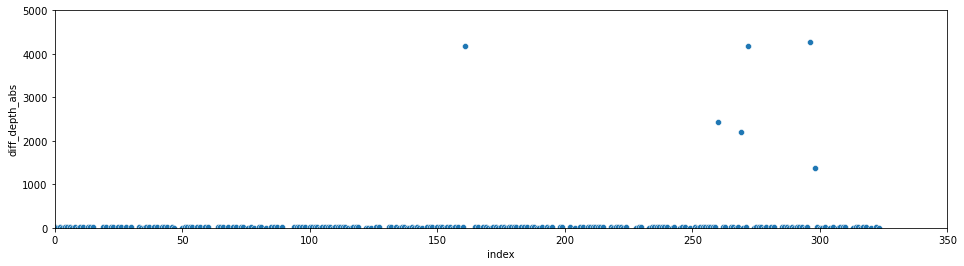

In [274]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(16,4))

sns.scatterplot(data=Eaglebine_Combined_cln.reset_index(), x="index", y="diff_depth_abs")

ax.set_xlim([0, 350])
ax.set_ylim([0, 5000])

In [275]:
# display the combined file sorted by depth difference
Eaglebine_Combined_cln_sorted = Eaglebine_Combined_cln.sort_values (by=['diff_depth_abs'], ascending=False)
RelevantCl = ['UWI',  'diff_depth_abs', 'diff_depth', 'index in TT DF','BHT_below sea level (ft)', 'Depth sub-sea (feet)', 'TempC_BHT', 'TempTrue_degC']
Eaglebine_Combined_cln_sorted[RelevantCl].head(10)

,UWI,diff_depth_abs,diff_depth,index in TT DF,BHT_below sea level (ft),Depth sub-sea (feet),TempC_BHT,TempTrue_degC
296,42395304440000,4279.0,-4279.0,61402.0,15379.0,11100.0,181.111111,131.188889
272,42311317850000,4182.0,-4182.0,56335.0,19132.0,14950.0,166.666667,168.805556
161,42161304400000,4174.0,-4174.0,33393.0,14824.0,10650.0,166.111111,130.283333
260,42289315440000,2438.0,-2438.0,53615.0,13388.0,10950.0,150.000000,131.272222
269,42311001580000,2209.3,-2209.3,55365.0,16609.3,14400.0,156.666667,164.161111
298,42395307330000,1372.0,-1372.0,61609.0,11122.0,9750.0,112.222222,119.105556
117,42123309360000,24.9,-24.9,23783.0,2124.9,2100.0,42.222222,46.622222
291,42395302880000,24.3,24.3,60178.0,13875.7,13900.0,151.666667,152.622222
140,42127317020000,24.0,-24.0,28468.0,7774.0,7750.0,87.222222,107.355556
318,42493319370000,24.0,24.0,65660.0,6876.0,6900.0,78.888889,100.472222


In [276]:
# Preparation for the true temperature correction. We will align all the temperatures to the BHT depth
# When True depth is shallower than BHT, True temperature has to be increased by the temp gradient * depth diff
TrueDepthShallower = ((Eaglebine_Combined_cln['diff_depth_abs'] + Eaglebine_Combined_cln['diff_depth']) == 0).sum()
TrueDepthShallower

114

In [277]:
# When True depth is deeper than BHT, True temperature has to be deacresed by the temp gradient * depth diff
TrueDepthDeeper = ((Eaglebine_Combined_cln['diff_depth_abs'] + Eaglebine_Combined_cln['diff_depth']) != 0).sum()
TrueDepthDeeper

210

In [278]:
# in case True temperature < BHT, we set at least to the same value
Cooler = ((Eaglebine_Combined_cln['TempTrue_degC'] - Eaglebine_Combined_cln['TempC_BHT']) < 0).sum()
Cooler

11

<span style="color:blue;"> <b>
We are performing the True temperature correction using the temperature gradient
</b> </span>

In [279]:
if (ApplyTemperatureGradient):
    Eaglebine_Infos = {'df_Truth': Eaglebine_Truth,
                       'df_Combined_cln': Eaglebine_Combined_cln,
                       'BHT Temp': 'TempC_BHT',   
                       'True Temp': 'TempTrue_degC',
                       'NC True Temp': 'NCTempTrue_degC',
                       'Depth': 'Depth sub-sea (feet)'
                      }

    TempGradientCorrection(Eaglebine_Infos)

In [280]:
# display the combined file sorted by depth difference after the temperature gradient correction
if (ApplyTemperatureGradient):
    Eaglebine_Combined_cln_sorted = Eaglebine_Combined_cln.sort_values (by=['diff_depth_abs'], ascending=False)
    Eaglebine_Combined_cln_sorted.head(15)

In [281]:
if (ApplyTemperatureGradient):
    print('-- statistics for Original True temperature (the row with N/A True temperature are not taken in account)')
    print(Eaglebine_Combined_cln.dropna(subset=['TempTrue_degC'])['NCTempTrue_degC'].describe())
    print()
    print('-- statistics for Corrected True temperature (the row with N/A True temperature are not taken in account)')
    print(Eaglebine_Combined_cln.dropna(subset=['TempTrue_degC'])['TempTrue_degC'].describe())
    print()
    print('-- statistics for Temperature gradient''s slope (the row with N/A True temperature are not taken in account)')
    print(Eaglebine_Combined_cln.dropna(subset=['TempTrue_degC'])['Slope'].describe())
    print()
    print('-- statistics for Temperature gradient''s correlation (the row with N/A True temperature are not taken in account)')
    print(Eaglebine_Combined_cln.dropna(subset=['TempTrue_degC'])['Correlation'].describe())
    print()

In [282]:
# in case True temperature < BHT, we set at least to the same value
Cooler = ((Eaglebine_Combined_cln['TempTrue_degC'] - Eaglebine_Combined_cln['TempC_BHT']) < 0).sum()
Cooler

11

## 2.4 Read in static temperature information and merge into dataset

In [283]:
Static_log_temp = pd.read_csv(dir_datathon+'Data_static_logs.csv')
Static_log_temp.head()

,Well_ID,Depth (ft),Temp (degC),Field
0,42013301930000,10700.0,132.778000,Eaglebine
1,42041305800000,7360.0,82.777778,Eaglebine
2,42041311700000,7828.0,118.888889,Eaglebine
3,42041311980000,7954.0,105.000000,Eaglebine
4,42051305380000,8380.0,111.111111,Eaglebine


In [284]:
# ---- debug
print("number of rows in Eaglebine static temperature information: " + str(len(Static_log_temp)))
print("number of unique wells in Eaglebine static temperature information: " + str(len(pd.unique(Static_log_temp['Well_ID']))))

number of rows in Eaglebine static temperature information: 41
number of unique wells in Eaglebine static temperature information: 41


In [285]:
Eaglebine_Combined_cln['UWI'] = Eaglebine_Combined_cln['UWI'].astype(str)
Eaglebine_Combined_cln = Eaglebine_Combined_cln.copy(deep=True)
Eaglebine_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Eaglebine_Combined_stat = Eaglebine_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [286]:
# Coalesce columns together with priority for true temperature measurements
Eaglebine_Combined_stat['TempC_Fin'] = Eaglebine_Combined_stat['TempTrue_degC']
Eaglebine_Combined_stat['TrueTemp_datasource'] = Eaglebine_Combined_stat['TrueTemp_datasource_stat'].fillna(Eaglebine_Combined_stat['TrueTemp_datasource_syn'])
Eaglebine_Combined_stat.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,...,Depth sub-sea (feet),TempTrue_degC,TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,...,12200.0,141.555556,synthetic,NaN,NaN,NaN,NaN,NaN,141.555556,synthetic
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,...,10400.0,132.038889,synthetic,42013301930000,10700.0,132.778,Eaglebine,static_temp_logs,132.038889,static_temp_logs
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,...,5750.0,89.161111,synthetic,NaN,NaN,NaN,NaN,NaN,89.161111,synthetic
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,...,7800.0,107.961111,synthetic,NaN,NaN,NaN,NaN,NaN,107.961111,synthetic
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,...,10500.0,133.722222,synthetic,NaN,NaN,NaN,NaN,NaN,133.722222,synthetic


In [287]:
# ---- debug
print("number of rows in Eaglebine final dataframe: " + str(len(Eaglebine_Combined_stat)))
print("number of unique wells in Eaglebine final dataframe: " + str(len(pd.unique(Eaglebine_Combined_stat['UWI']))))

number of rows in Eaglebine final dataframe: 324
number of unique wells in Eaglebine final dataframe: 324


## 2.5 plot the eaglebine temperature data

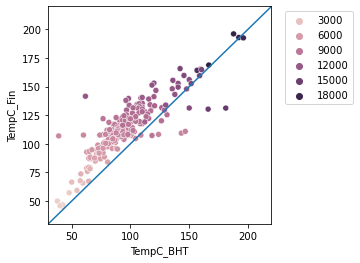

In [288]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Eaglebine_Combined_stat, x="TempC_BHT", y="TempC_Fin", hue='BHT_below sea level (ft)', ax=ax)

ax.set_xlim([30, 220])
ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## 2.6 Replace the visible outliers

In [289]:
# Add a new channel deltaT = TempC_Fin - TempC_BHT
# Display the combined file sorted by deltaT
Eaglebine_Combined_stat['deltaT'] = Eaglebine_Combined_stat['TempC_Fin'] - Eaglebine_Combined_stat['TempC_BHT']
Eaglebine_Combined_stat_sorted = Eaglebine_Combined_stat.sort_values (by=['deltaT'], ascending=False)
Eaglebine_Combined_stat_sorted.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,...,TempTrue_degC,TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource,deltaT
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.5,61.666667,...,141.555556,synthetic,NaN,NaN,NaN,NaN,NaN,141.555556,synthetic,79.888889
66,42051307650000,30.486666,-96.696238,7937.0,375.40,7580.00,7955.4,102.0,0.0,38.888889,...,106.866667,synthetic,NaN,NaN,NaN,NaN,NaN,106.866667,synthetic,67.977778
96,42051315190000,30.548019,-96.650337,8066.0,441.40,7637.00,8078.4,140.0,5.0,60.000000,...,107.616667,synthetic,NaN,NaN,NaN,NaN,NaN,107.616667,synthetic,47.616667
274,42313302370000,31.005779,-95.815109,11000.0,266.85,9143.55,9410.4,170.0,7.0,76.666667,...,121.950000,synthetic,NaN,NaN,NaN,NaN,NaN,121.950000,synthetic,45.283333
301,42477305280000,30.312019,-96.368828,13400.0,431.40,10898.00,11329.4,205.0,5.5,96.111111,...,137.894444,synthetic,42477305280000,13329.0,165.555556,Eaglebine,static_temp_logs,137.894444,static_temp_logs,41.783333


In [290]:
# stastistics on delta T
Eaglebine_Combined_stat_sorted['deltaT'].describe()

count    243.000000
mean      17.565638
std       13.176842
min      -49.922222
25%       12.355556
50%       18.572222
75%       23.683333
max       79.888889
Name: deltaT, dtype: float64

In [291]:
# I am setting a threshold to 47 on deltaT soley based on the 
Eaglebine_Combined_stat.loc[Eaglebine_Combined_stat.deltaT > 47, 'TempC_Fin'] = Eaglebine_Combined_stat['TempC_BHT'] + 47
Eaglebine_Combined_stat.loc[Eaglebine_Combined_stat.deltaT > 47, 'deltaT'] = 47

In [292]:
Eaglebine_Combined_stat_sorted = Eaglebine_Combined_stat.sort_values (by=['deltaT'], ascending=False)
Eaglebine_Combined_stat_sorted.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,...,TempTrue_degC,TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource,deltaT
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.5,61.666667,...,141.555556,synthetic,NaN,NaN,NaN,NaN,NaN,108.666667,synthetic,47.000000
66,42051307650000,30.486666,-96.696238,7937.0,375.40,7580.00,7955.4,102.0,0.0,38.888889,...,106.866667,synthetic,NaN,NaN,NaN,NaN,NaN,85.888889,synthetic,47.000000
96,42051315190000,30.548019,-96.650337,8066.0,441.40,7637.00,8078.4,140.0,5.0,60.000000,...,107.616667,synthetic,NaN,NaN,NaN,NaN,NaN,107.000000,synthetic,47.000000
274,42313302370000,31.005779,-95.815109,11000.0,266.85,9143.55,9410.4,170.0,7.0,76.666667,...,121.950000,synthetic,NaN,NaN,NaN,NaN,NaN,121.950000,synthetic,45.283333
301,42477305280000,30.312019,-96.368828,13400.0,431.40,10898.00,11329.4,205.0,5.5,96.111111,...,137.894444,synthetic,42477305280000,13329.0,165.555556,Eaglebine,static_temp_logs,137.894444,static_temp_logs,41.783333


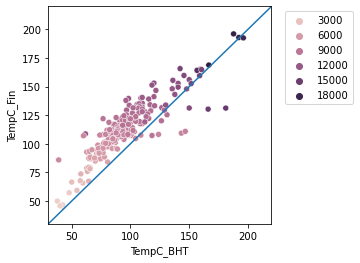

In [293]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Eaglebine_Combined_stat, x="TempC_BHT", y="TempC_Fin", hue='BHT_below sea level (ft)', ax=ax)

ax.set_xlim([30, 220])
ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 3 Organize Duvernay temperature data

## 3.1 Read in DST BHT input and "true temp" synthetic data

In [294]:
Duvernay_Truth = pd.read_excel(dir_duvernay+'Duvernay TrueTemp_Train.xlsx')
Duvernay_DST = pd.read_excel(dir_duvernay+'Duvernay DST BHT for SPE April 20 2021.xlsx')
Duvernay_Truth.head()

,UWI,Depths subsea (m),True Temperature (oC)
0,100010107020W500,-720,2.53
1,100010107020W500,-700,2.54
2,100010107020W500,-680,2.54
3,100010107020W500,-660,3.30
4,100010107020W500,-640,4.06


In [295]:
# Keep the True temperature index for the subsequent correction using temperature gradient
# Note that pandas merge will convert the index type from int to float during the merge process
# We will have to revert it to int during the tempaerature gradient correction
Duvernay_Truth['index in TT DF'] = Duvernay_Truth.index
Duvernay_Truth.head()

,UWI,Depths subsea (m),True Temperature (oC),index in TT DF
0,100010107020W500,-720,2.53,0
1,100010107020W500,-700,2.54,1
2,100010107020W500,-680,2.54,2
3,100010107020W500,-660,3.30,3
4,100010107020W500,-640,4.06,4


In [296]:
# add in an extra column calculating the depth sub sea (elevation-depth)*-1 
Duvernay_DST['Depth_SS(m)']=-1*(Duvernay_DST['elevation M above sea level']-(Duvernay_DST['DST Start Depth (MD) (m)']+Duvernay_DST['DST End Depth (MD) (m)'])/2)
Duvernay_DST.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m)
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,645.6,100010608109W500,1044.4
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,1283.8,100010904012W500,2424.2
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,651.6,100011206021W400,171.9
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,873.1,100011506915W500,936.4


In [297]:
# merge
Duvernay_Combined = Duvernay_DST.merge(Duvernay_Truth, on='UWI', how='left')
Duvernay_Combined.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m),Depths subsea (m),True Temperature (oC),index in TT DF
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-720.0,2.53,0.0
1,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-700.0,2.54,1.0
2,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-680.0,2.54,2.0
3,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-660.0,3.30,3.0
4,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,-640.0,4.06,4.0


In [298]:
# keep only the synthetic model temperature data for the relevant depths for which there is BHT measurement
Duvernay_Combined['diff_depth'] = Duvernay_Combined['Depth_SS(m)']-Duvernay_Combined['Depths subsea (m)']
Duvernay_Combined['diff_depth_abs'] = np.abs(Duvernay_Combined['diff_depth'])
idx = Duvernay_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Duvernay_Combined['diff_depth_abs']
TrueTempUWI = Duvernay_Combined.loc[idx, ['UWI', 'index in TT DF', 'diff_depth_abs', 'diff_depth', 'True Temperature (oC)']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Duvernay_Combined_cln = Duvernay_DST.merge(TrueTempUWI, on='UWI', how='left')
Duvernay_Combined_cln = Duvernay_Combined_cln.drop_duplicates(['UWI'])
Duvernay_Combined_cln.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,elevation M above sea level,UWI,Depth_SS(m),index in TT DF,diff_depth_abs,diff_depth,True Temperature (oC)
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,701.0,100010107020W500,716.0,72.0,4.0,-4.0,60.97
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,645.6,100010608109W500,1044.4,812.0,4.4,4.4,63.98
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,1283.8,100010904012W500,2424.2,NaN,NaN,NaN,NaN
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,651.6,100011206021W400,171.9,2180.0,8.1,-8.1,39.07
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,873.1,100011506915W500,936.4,3422.0,3.6,-3.6,69.47


<span style="color:blue;"> <b>
We have 512 wells but only 372 have true temperature (only the one that has depth difference value) <br> 
But this time, unlike in Eaglebine, the range of depth difference (from 0 ft to 9.85 ft) with a mean  of 4.95 ft and std of 2.90 ft is reasonable. <br>
In a subsequent version, we will also check if it is necesary to make a temperature correction due to the depth difference
</b> </span>

In [299]:
len(Duvernay_Combined_cln)

512

In [300]:
# display the combined file sorted by depth difference
Duvernay_Combined_cln_sorted = Duvernay_Combined_cln.sort_values (by=['diff_depth_abs'], ascending=False)
RelevantCl = ['UWI',  'diff_depth_abs', 'diff_depth', 'index in TT DF','elevation M above sea level', 'Depth_SS(m)', 'DST Bottom Hole Temp. (degC)', 'True Temperature (oC)']
Duvernay_Combined_cln_sorted[RelevantCl].head()

,UWI,diff_depth_abs,diff_depth,index in TT DF,elevation M above sea level,Depth_SS(m),DST Bottom Hole Temp. (degC),True Temperature (oC)
138,100060905918W500,9.85,-9.85,90254.0,1074.7,1250.15,77.78,86.74
125,100060305107W500,9.85,9.85,84701.0,824.2,969.85,33.33,67.15
26,100021406418W500,9.85,9.85,19800.0,820.5,1429.85,98.89,81.52
163,100062306318W500,9.80,-9.80,105553.0,806.2,2150.20,88.89,100.23
257,100100105619W500,9.75,-9.75,165593.0,1110.3,1650.25,84.60,101.99


<span style="color:blue;"> <b>
We are performing the True temperature correction using the temperature gradient
</b> </span>

In [301]:
if (ApplyTemperatureGradient):
    Duvernay_Infos = {'df_Truth': Duvernay_Truth,
                      'df_Combined_cln': Duvernay_Combined_cln,
                      'BHT Temp': 'DST Bottom Hole Temp. (degC)',   
                      'True Temp': 'True Temperature (oC)',
                      'NC True Temp': 'NCTrue Temperature (oC)',
                      'Depth': 'Depths subsea (m)'
                      }

    TempGradientCorrection(Duvernay_Infos)

In [302]:
if (ApplyTemperatureGradient):
    # display the combined file sorted by depth difference after the temperature gradient correction
    Duvernay_Combined_cln_sorted = Duvernay_Combined_cln.sort_values (by=['diff_depth_abs'], ascending=False)
    Duvernay_Combined_cln_sorted.head(15)

## 3.2 Merge in static temperature log data

In [303]:
Duvernay_Combined_cln['UWI'] = Duvernay_Combined_cln['UWI'].astype(str)
Duvernay_Combined_cln = Duvernay_Combined_cln.copy(deep=True)
Duvernay_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Duvernay_Combined_stat = Duvernay_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [304]:
Static_log_temp.head()

,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat
0,42013301930000,10700.0,132.778000,Eaglebine,static_temp_logs
1,42041305800000,7360.0,82.777778,Eaglebine,static_temp_logs
2,42041311700000,7828.0,118.888889,Eaglebine,static_temp_logs
3,42041311980000,7954.0,105.000000,Eaglebine,static_temp_logs
4,42051305380000,8380.0,111.111111,Eaglebine,static_temp_logs


In [305]:
# Coalesce columns together with priority for true temperature measurements
#Duvernay_Combined_stat['TempC_Fin'] = Duvernay_Combined_stat['Temp (degC)'].fillna(Duvernay_Combined_stat['True Temperature (oC)'])
Duvernay_Combined_stat['TempC_Fin'] = Duvernay_Combined_stat['True Temperature (oC)']
#Duvernay_Combined_stat['TrueTemp_datasource'] = Duvernay_Combined_stat['TrueTemp_datasource_stat'].fillna(Duvernay_Combined_stat['TrueTemp_datasource_syn'])

Duvernay_Combined_stat.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,...,diff_depth_abs,diff_depth,True Temperature (oC),TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,...,4.0,-4.0,60.97,synthetic,NaN,NaN,NaN,NaN,NaN,60.97
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,...,4.4,4.4,63.98,synthetic,NaN,NaN,NaN,NaN,NaN,63.98
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,...,NaN,NaN,NaN,synthetic,NaN,NaN,NaN,NaN,NaN,NaN
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,...,8.1,-8.1,39.07,synthetic,NaN,NaN,NaN,NaN,NaN,39.07
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,...,3.6,-3.6,69.47,synthetic,NaN,NaN,NaN,NaN,NaN,69.47


## 3.3 Plot the temp data

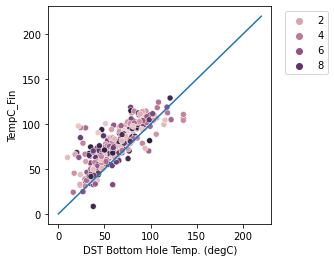

In [306]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Duvernay_Combined_stat, 
                x="DST Bottom Hole Temp. (degC)",
                y="TempC_Fin",
                hue='diff_depth_abs', ax=ax)

#ax.set_xlim([30, 220])
#ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 4 Combine Eaglebine and Duvernay temperature datasets

In [307]:
Eaglebine_Combined_stat.head()

,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,...,TempTrue_degC,TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource,deltaT
0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,61.666667,...,141.555556,synthetic,NaN,NaN,NaN,NaN,NaN,108.666667,synthetic,47.000000
1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,107.222222,...,132.038889,synthetic,42013301930000,10700.0,132.778,Eaglebine,static_temp_logs,132.038889,static_temp_logs,24.816667
2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,65.555556,...,89.161111,synthetic,NaN,NaN,NaN,NaN,NaN,89.161111,synthetic,23.605556
3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,76.666667,...,107.961111,synthetic,NaN,NaN,NaN,NaN,NaN,107.961111,synthetic,31.294444
4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,98.888889,...,133.722222,synthetic,NaN,NaN,NaN,NaN,NaN,133.722222,synthetic,34.833333


In [308]:
Duvernay_Combined_stat.head()

,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,Unnamed: 9,...,diff_depth_abs,diff_depth,True Temperature (oC),TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,NaN,...,4.0,-4.0,60.97,synthetic,NaN,NaN,NaN,NaN,NaN,60.97
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,NaN,...,4.4,4.4,63.98,synthetic,NaN,NaN,NaN,NaN,NaN,63.98
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,NaN,...,NaN,NaN,NaN,synthetic,NaN,NaN,NaN,NaN,NaN,NaN
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,NaN,...,8.1,-8.1,39.07,synthetic,NaN,NaN,NaN,NaN,NaN,39.07
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,NaN,...,3.6,-3.6,69.47,synthetic,NaN,NaN,NaN,NaN,NaN,69.47


In [309]:
Eaglebine = Eaglebine_Combined_stat[['UWI', 'TempC_BHT', 'TempC_Fin', 'TD (ft)','TSC or ORT (time since circulation or original recorded time in hours)']]
Eaglebine = Eaglebine.rename(columns={'TempC_BHT': 'BHT', 'TempC_Fin': 'TrueTemp'})
Eaglebine['Field'] = 'Eaglebine'

Duvernay = Duvernay_Combined_stat[['UWI', 'DST Bottom Hole Temp. (degC)', 'TempC_Fin','Depth_SS(m)', 'DST Start Depth (MD) (m)', 'DST End Depth (MD) (m)','elevation M above sea level' ]]
Duvernay = Duvernay.rename(columns={'DST Bottom Hole Temp. (degC)': 'BHT', 'TempC_Fin': 'TrueTemp'})
Duvernay['Field'] = 'Duvernay'

#combined_temperature = pd.concat((Duvernay, Eaglebine))
#combined_temperature.head()

In [310]:
# save this structured data to file
! mkdir StructuredData
Duvernay.to_csv('StructuredData/Duvernay.csv', index=False)
Eaglebine.to_csv('StructuredData/Eaglebine.csv', index=False)

A subdirectory or file StructuredData already exists.


In [311]:
Eaglebine.head()

,UWI,BHT,TrueTemp,TD (ft),TSC or ORT (time since circulation or original recorded time in hours),Field
0,42013301410000,61.666667,108.666667,19629.0,5.50,Eaglebine
1,42013301930000,107.222222,132.038889,10775.0,11.00,Eaglebine
2,42013302760000,65.555556,89.161111,6168.0,5.50,Eaglebine
3,42013305480000,76.666667,107.961111,8198.0,5.00,Eaglebine
4,42013310190000,98.888889,133.722222,11000.0,7.75,Eaglebine


In [312]:
Duvernay.head()

,UWI,BHT,TrueTemp,Depth_SS(m),DST Start Depth (MD) (m),DST End Depth (MD) (m),elevation M above sea level,Field
0,100010107020W500,48.33,60.97,716.0,1410.6,1423.4,701.0,Duvernay
1,100010608109W500,34.26,63.98,1044.4,1686.0,1694.0,645.6,Duvernay
2,100010904012W500,104.40,NaN,2424.2,3698.0,3718.0,1283.8,Duvernay
3,100011206021W400,29.00,39.07,171.9,822.0,825.0,651.6,Duvernay
4,100011506915W500,64.00,69.47,936.4,1801.0,1818.0,873.1,Duvernay


In [314]:
len(Duvernay)

512

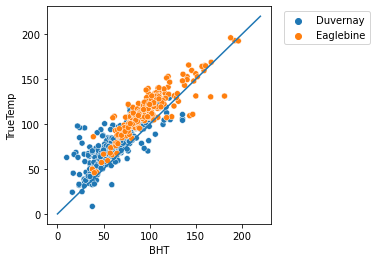

In [315]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Duvernay, x="BHT", y="TrueTemp", hue='Field', palette=['tab:blue'], ax=ax)
sns.scatterplot(data=Eaglebine, x="BHT", y="TrueTemp", hue='Field', palette=['tab:orange'], ax=ax)

ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# 5 Organize Mud-weight, formation, well header, and production data

This section consolidates the files provided by GTS. List of imported files and the dataframe names:

- Eaglebine mud weight SPE April 21 2021.xlsx: **EB_MW**
- Eaglebine formation tops SPE April 20 2021.xlsx: **EB_FT**
- Eaglebine well headers SPE April 21 2021.xlsx: **EB_WH**
- SPE Eaglebine production summary April 20 2021.xlsx: **EB_PS**
- Duvernay formation tops SPE April 20 2021.xlsx: **DV_FT**
- Duvernay well headers SPE April 21 2021 .xlsx: **DV_WH**
- SPE Duvernay production summary April 20 2021.xlsx: **DV_PS**

**Workflow: add the multiple entries as attributes**

1. read the excel file into a dataframe. Leave the indexing out at this stage.
1. for each well number (Well_Id), tag the multiple entries in a new column.
    - New column name: 'attribute_' + the name of the column with multiple entries.
    - Tag: name of the column with multiple entries + sequential number for multiple entries in that column
1. reshape the featured table to pivot on the attribute
1. check for dupblicates on 'Well_Id' after reshaping. If duplicates exist inspect all columns for each well. If no duplicates, it's ready for merge


(Thanks Korang Modaressi for code)

# 6 Organize LAS file

In [ ]:
### Thanks to Pushpesh Sharma for writing this section

In [316]:
import os
#!pip install lasio
import lasio

## 6.1 Checking for the best LAS curves to use

In [317]:
#Load all files at once into las and las_df to save time
folder='clean_las_files/Clean_LAS/'
all_files = os.listdir(folder)
n_files = len(all_files)

bad_files = []

las = {}
las_df = {}
mnemonics ={}
i=0
for filename in tqdm(os.listdir(folder)):
    i=i+1
    if filename.endswith(".LAS"):
        las[filename] = lasio.read(folder+'/'+filename)
        las_df[filename] = las[filename].df()
        mnemonics[filename] = las_df[filename].columns

In [318]:
#find out which well curves/logs are in each las file
listDF = []
for filename in tqdm(all_files):
    df = pd.DataFrame(columns = list(mnemonics[filename]), data = np.ones((1,len(mnemonics[filename]))))
    df['well_name']=filename
    listDF.append(df)

In [319]:
log_table=pd.concat(listDF)

In [320]:
# display the list of the most used curves
sumT = log_table.drop(columns=['well_name']).sum()
sumT.sort_values(ascending=False).head(50)

SPR         797.0
GRWS        660.0
DRESWS      657.0
CONDWS      656.0
CALWS       650.0
SRESWS      649.0
SPWS        644.0
SPRED       640.0
ILD         639.0
ILDED       516.0
DT          512.0
DTWS        509.0
DTED        454.0
ILM         441.0
MRESWS      436.0
GRS         425.0
GRSED       423.0
DENWS       411.0
DCORWS      405.0
RHOB        376.0
GRD         360.0
CALD        351.0
CALS        344.0
CALSED      340.0
ILMED       339.0
RHOBED      312.0
GRDED       309.0
DPHI_LS     307.0
DRHO        300.0
DPHILSED    297.0
GRR         295.0
CALDED      284.0
DPOLSWS     284.0
NPHI_LS     282.0
NPOLSWS     281.0
NPHILSED    279.0
CILD        276.0
DPHI_SS     246.0
CILDED      244.0
DPHISSED    243.0
NPHI_SS     236.0
DRHOED      232.0
NPHISSED    232.0
SN          197.0
SFLU        195.0
SNED        194.0
GRRED       189.0
LL8         153.0
LL8ED       138.0
SFLUED      138.0
dtype: float64

In [321]:
CurvesList = sumT.sort_values(ascending=False).head(50).index.tolist()
CurvesList

['SPR',
 'GRWS',
 'DRESWS',
 'CONDWS',
 'CALWS',
 'SRESWS',
 'SPWS',
 'SPRED',
 'ILD',
 'ILDED',
 'DT',
 'DTWS',
 'DTED',
 'ILM',
 'MRESWS',
 'GRS',
 'GRSED',
 'DENWS',
 'DCORWS',
 'RHOB',
 'GRD',
 'CALD',
 'CALS',
 'CALSED',
 'ILMED',
 'RHOBED',
 'GRDED',
 'DPHI_LS',
 'DRHO',
 'DPHILSED',
 'GRR',
 'CALDED',
 'DPOLSWS',
 'NPHI_LS',
 'NPOLSWS',
 'NPHILSED',
 'CILD',
 'DPHI_SS',
 'CILDED',
 'DPHISSED',
 'NPHI_SS',
 'DRHOED',
 'NPHISSED',
 'SN',
 'SFLU',
 'SNED',
 'GRRED',
 'LL8',
 'LL8ED',
 'SFLUED']

In [322]:
# Unit and description of the 50 most used curves
CurvesToRemoveFromList = []
for filename in tqdm(os.listdir(folder)):
    if filename.endswith(".LAS"):
        las = lasio.read(folder+'/'+filename)
        for CurvesToRemove in CurvesToRemoveFromList:
            CurvesList.remove(CurvesToRemove)
        CurvesToRemoveFromList = []
        for Curve in  CurvesList:
            LASCurve = las.get_curve(Curve)
            if(LASCurve is not None):
                print ('%-8s %-6s %-60s' % (LASCurve.mnemonic, LASCurve.unit, LASCurve.descr))                
                CurvesToRemoveFromList.append(Curve)
                break           

GRWS     GAPI   GAMMA RAY [GRSED]                                           
SPR      MV     SPONTANEOUS POTENTIAL FROM RESISTIVITY LOG                  
DRESWS   OHMM   DEEP RESISTIVITY [IDPHED]                                   
RHOB     KG/M3  BULK DENSITY FROM DENSITY LOG                               
CONDWS   MMHO   CONDUCTIVITY [1000/DRESWS]                                  
ILD      OHMM   INDUCTION DEEP RESISTIVITY                                  
CALWS    MM     CALIPER [CALDED]                                            
DT       US/M   DELTA-T (INTERVAL TRANSIT TIME)                             
SRESWS   OHMM   SHALLOW RESISTIVITY [SFLUED]                                
ILM      OHMM   MEDIUM INDUCTION FROM RESISTIVITY LOG                       
SPWS     MV     SPONTANEOUS POTENTIAL [BASELINE 0 MV] [SPRED]               
GRS      GAPI   GAMMA RAY FROM SONIC LOG                                    
SPRED    MV     SPONTANEOUS POTENTIAL FROM RESISTIVITY LOG                  

In [323]:
#TODO
# Curves selection and units check
# The unit listed above for a given curve is the unit for thenfirst occurence of the curve among all the logs
# Now, we are verifying that the same unit is used everywhere
# The curves selected are: GRSW, DRESWS, RHOB, ILD

## LAS Curves selected

In [324]:
LASCurves = ['GRWS', 'DRESWS', 'RHOB', 'ILD']     

## 6.2 Integrating the selected LAS curve unto the Eaglebine dataframe

In [254]:
# imputation for nan replacement
# the dataframe has to be sorted by ascendant depth before applying the replacement
# any nan value is replaced by the closest (by depth) valid value
#
def LASImputation(dataF):

    # sort the data frame by depth
    #
    dataF_sorted = dataF.sort_values (by=['DEPT'])
    
    print(dataF_sorted.head())
    for Curve in LASCurves:
        #in case the first value is a nan, it has to be replaced by he closest one before performing the main loop
        i = 0
        while (np.isnan(dataF_sorted.iloc[i][Curve])):
            i = i + 1
        j = i    
        ValidValue = dataF_sorted.iloc[j][Curve]    
        for i in range(0, j, 1):
            dataF_sorted.loc[i, [Curve]] = ValidValue

        # main loop    
        ValidValue = dataF_sorted.iloc[0][Curve]
        for i in range(0, len(dataF_sorted), 1):
            print('record ='+str(i))
            if (np.isnan(dataF_sorted.iloc[i][Curve])):
                print(Curve, '  ', dataF_sorted.loc[i, [Curve]])
                dataF_sorted.loc[i, [Curve]] = ValidValue
                print(Curve, '  ', dataF_sorted.loc[i, [Curve]])
            else:
                ValidValue = dataF_sorted.iloc[i][Curve]  
                
    print(dataF_sorted.head())
    print(dataF.head())

### 6.2.1 Read from LAS file based on depth

In [ ]:
# Final version for Eaglebine

FirstTime = True 

for Curve in LASCurves:
    # loop on the files in the folder
    folder = 'clean_las_files/Test/'
    for filename in tqdm(os.listdir(folder)):
        # read the LAS file and check:
        # - if the required curve is available
        # - if the UWI is available in Duvenay
        lasfile = lasio.read(folder+filename)
        UWI = lasfile.well.UWI.value
        if (lasfile.get_curve(Curve)) is not None:
            row = 0
            while ((Eaglebine.iloc[row]['UWI'] != UWI) and (row < (len(Eaglebine) - 1))):
                row = row + 1
            if (row <  len(Eaglebine)):            
                # create a corresponding data frame and add UWI
                # there is no need to add the depth
                # in fact, the data frame creator uses the depth 'DEPT' as an index        
                lasdf = lasfile.df()
                lasdf['UWI'] = UWI
                # we have to remove the dept as index to use to be compatible with all our data frames
                lasdf.reset_index(inplace=True)
                # depth unit conversion
                # the depth for the Eaglebine data frame is in feet
                if (lasfile.curves.DEPT.unit == 'M'):
                    lasdf['DEPT'] = lasdf['DEPT'] / 0.3048
        
                # we combine it with the LAS data frame with the Eaglebine data frame
                Eaglebine_withLAS = Eaglebine.merge(lasdf, on='UWI', how='left') 
                
                # this code combine the selected curve from LAS at the right depth
                Eaglebine_withLAS['diff_depth'] = Eaglebine_withLAS['TD (ft)'] - Eaglebine_withLAS['DEPT']
                Eaglebine_withLAS['diff_depth_abs'] = np.abs(Eaglebine_withLAS['diff_depth'])
                idx = Eaglebine_withLAS.groupby(['UWI'])['diff_depth_abs'].transform(min) == Eaglebine_withLAS['diff_depth_abs']

                if (idx.sum() == 1):
                    TrueTempUWI = Eaglebine_withLAS.loc[idx, ['diff_depth_abs', 'DEPT', Curve]]
                    
                    #  The additional channels
                    if (FirstTime):
                        Eaglebine_withLAS_final = Eaglebine.copy() 
                        Eaglebine_withLAS_final['DEPT'] = np.nan 
                        Eaglebine_withLAS_final['diff_depth_abs'] = np.nan 
                        FirstTime = False

                    # the optional channel has to be checked , otherwise we will end up with multiple channels with the same name
                    if (Curve not in Eaglebine_withLAS_final):
                        Eaglebine_withLAS_final[Curve] = np.nan 
                
                    diff_depth_abs = TrueTempUWI.iloc[0,0] 
                    depth = TrueTempUWI.iloc[0,1]
                    NewCurve = TrueTempUWI.iloc[0,2]

                    Eaglebine_withLAS_final.loc[row, ['DEPT']] = depth
                    Eaglebine_withLAS_final.loc[row, ['diff_depth_abs']] = diff_depth_abs
                    Eaglebine_withLAS_final.loc[row, [Curve]] = NewCurve            
                                        
Eaglebine_withLAS_final.head()
            


In [ ]:
Eaglebine_withLAS_final.tail(50)

In [ ]:
Eaglebine_withLAS_final['diff_depth_abs'].describe()

## 6.3 Integrating the selected LAS curve unto the Duvernay dataframe

### 6.3.1 Read from LAS file based on depth

In [ ]:
# Final version for Duvernay

FirstTime = True 

for Curve in LASCurves:
    # loop on the files in the folder
    folder = 'clean_las_files/Clean_LAS/'
    for filename in tqdm(os.listdir(folder)):
        # read the LAS file and check:
        # - if the required curve is available
        # - if the UWI is available in Duvenay
        lasfile = lasio.read(folder+filename)
        UWI = lasfile.well.UWI.value
        if (lasfile.get_curve(Curve)) is not None:
            row = 0
            while ((Duvernay.iloc[row]['UWI'] != UWI) and (row < (len(Duvernay) - 1))):
                row = row + 1
            if (row <  len(Duvernay)):            
                # create a corresponding data frame and add UWI
                # there is no need to add the depth
                # in fact, the data frame creator uses the depth 'DEPT' as an index        
                lasdf = lasfile.df()
                lasdf['UWI'] = UWI
                # we have to remove the dept as index to use to be compatible with all our data frames
                lasdf.reset_index(inplace=True)
                # depth unit conversion
                # the depth for the Duvernay data frame is in meter
                if ((lasfile.curves.DEPT.unit == 'FT') or(lasfile.curves.DEPT.unit == 'F')):
                    lasdf['DEPT'] = lasdf['DEPT'] * 0.3048
        
                # we combine it with the LAS data frame with the Duvernay data frame
                Duvernay_withLAS = Duvernay.merge(lasdf, on='UWI', how='left') 

                # this code combine the selected curve from LAS at the right depth
                Duvernay_withLAS['diff_depth'] = Duvernay_withLAS['Depth_SS(m)'] - Duvernay_withLAS['DEPT']
                Duvernay_withLAS['diff_depth_abs'] = np.abs(Duvernay_withLAS['diff_depth'])
                idx = Duvernay_withLAS.groupby(['UWI'])['diff_depth_abs'].transform(min) == Duvernay_withLAS['diff_depth_abs']

                if (idx.sum() == 1):
                    TrueTempUWI = Duvernay_withLAS.loc[idx, ['diff_depth_abs', 'DEPT', Curve]]

                    #  The additional channels
                    if (FirstTime):
                        Duvernay_withLAS_final = Duvernay.copy() 
                        Duvernay_withLAS_final['DEPT'] = np.nan 
                        Duvernay_withLAS_final['diff_depth_abs'] = np.nan 
                        FirstTime = False

                    # the optional channel has to be checked , otherwise we will end up with multiple channels with the same name
                    if (Curve not in Duvernay_withLAS_final):
                        Duvernay_withLAS_final[Curve] = np.nan 
                
                    diff_depth_abs = TrueTempUWI.iloc[0,0] 
                    depth = TrueTempUWI.iloc[0,1]
                    NewCurve = TrueTempUWI.iloc[0,2]

                    Duvernay_withLAS_final.loc[row, ['DEPT']] = depth
                    Duvernay_withLAS_final.loc[row, ['diff_depth_abs']] = diff_depth_abs
                    Duvernay_withLAS_final.loc[row, [Curve]] = NewCurve            
                                        
Duvernay_withLAS_final.head()
            


### 6.3.2 Imputation

In [ ]:
#LASImputation(Duvernay_withLAS_final)

In [ ]:
OriginalIndex = Duvernay_withLAS_final['UWI'].copy()
Duvernay_sorted = Duvernay_withLAS_final.sort_values (by=['DEPT']).copy()
Duvernay_sorted.head()

In [ ]:
Duvernay_resorted = Duvernay_sorted.reset_index(drop=True)

In [ ]:
Duvernay_resorted.head()

In [250]:
# imputation for nan replacement
# the dataframe has to be sorted by ascendant depth before applying the replacement
# any nan value is replaced by the closest (by depth) valid value
#
#Duvernay_sorted = Duvernay_withLAS_final.sort_values (by=['DEPT'])
#Duvernay_sorted = Duvernay_withLAS_final
    
for Curve in LASCurves:
    #in case the first value is a nan, it has to be replaced by he closest one before performing the main loop
    i = 0
    while (np.isnan(Duvernay_resorted.iloc[i][Curve])):
        i = i + 1
    j = i    
    ValidValue = Duvernay_resorted.iloc[j][Curve]    
    for i in range(0, j, 1):
        Duvernay_resorted.loc[i, [Curve]] = ValidValue

    # main loop    
    ValidValue = Duvernay_resorted.iloc[0][Curve]
    for i in range(0, len(Duvernay_resorted), 1):
        if (np.isnan(Duvernay_resorted.iloc[i][Curve])):
            Duvernay_resorted.loc[i, [Curve]] = ValidValue
        else:
            ValidValue = Duvernay_resorted.iloc[i][Curve]  


In [ ]:
Duvernay_resorted.head()

In [ ]:
OriginalIndex 

In [ ]:
df = pd.DataFrame([OriginalIndex]).transpose()

In [ ]:
df

In [ ]:
Duvernay_Final = df.merge(Duvernay_resorted, on='UWI', how='left')

In [ ]:
Duvernay_Final

In [ ]:
Duvernay_withLAS_final.head()

In [ ]:
Duvernay_Final.head()

In [259]:
df.head()

,UWI
0,100010107020W500
1,100010608109W500
2,100010904012W500
3,100011206021W400
4,100011506915W500


In [260]:
Duvernay_sorted = Duvernay_withLAS_final.sort_values (by=['DEPT']).copy()
Duvernay_sorted.head()

,UWI,BHT,TrueTemp,Depth_SS(m),DST Start Depth (MD) (m),DST End Depth (MD) (m),elevation M above sea level,Field,DEPT,diff_depth_abs,GRWS,DRESWS,RHOB,ILD
243,100090107716W500,26.67,26.777898,-226.8,467.9,481.6,708.4,Duvernay,91.44,318.24,65.2301,NaN,NaN,NaN
276,100101007809W500,37.78,37.780000,-27.4,623.3,635.5,662.9,Duvernay,91.44,118.84,81.0672,2.5141,NaN,NaN
152,100061504803W500,29.44,34.912421,107.0,965.6,969.3,862.3,Duvernay,106.68,0.32,NaN,5.4441,NaN,NaN
511,106141105522W400,23.33,33.790024,128.9,701.0,762.0,633.1,Duvernay,121.92,6.98,61.5996,NaN,NaN,NaN
341,100102708009W500,34.44,NaN,-89.9,545.0,560.2,650.1,Duvernay,198.12,288.02,59.3498,5.4486,NaN,5.4434


In [261]:
Duvernay_resorted = Duvernay_sorted.reset_index().drop(columns=['index']).copy()
Duvernay_resorted.head()

,UWI,BHT,TrueTemp,Depth_SS(m),DST Start Depth (MD) (m),DST End Depth (MD) (m),elevation M above sea level,Field,DEPT,diff_depth_abs,GRWS,DRESWS,RHOB,ILD
0,100090107716W500,26.67,26.777898,-226.8,467.9,481.6,708.4,Duvernay,91.44,318.24,65.2301,NaN,NaN,NaN
1,100101007809W500,37.78,37.780000,-27.4,623.3,635.5,662.9,Duvernay,91.44,118.84,81.0672,2.5141,NaN,NaN
2,100061504803W500,29.44,34.912421,107.0,965.6,969.3,862.3,Duvernay,106.68,0.32,NaN,5.4441,NaN,NaN
3,106141105522W400,23.33,33.790024,128.9,701.0,762.0,633.1,Duvernay,121.92,6.98,61.5996,NaN,NaN,NaN
4,100102708009W500,34.44,NaN,-89.9,545.0,560.2,650.1,Duvernay,198.12,288.02,59.3498,5.4486,NaN,5.4434


In [262]:
Duvernay_resorted.head()

,UWI,BHT,TrueTemp,Depth_SS(m),DST Start Depth (MD) (m),DST End Depth (MD) (m),elevation M above sea level,Field,DEPT,diff_depth_abs,GRWS,DRESWS,RHOB,ILD
0,100090107716W500,26.67,26.777898,-226.8,467.9,481.6,708.4,Duvernay,91.44,318.24,65.2301,NaN,NaN,NaN
1,100101007809W500,37.78,37.780000,-27.4,623.3,635.5,662.9,Duvernay,91.44,118.84,81.0672,2.5141,NaN,NaN
2,100061504803W500,29.44,34.912421,107.0,965.6,969.3,862.3,Duvernay,106.68,0.32,NaN,5.4441,NaN,NaN
3,106141105522W400,23.33,33.790024,128.9,701.0,762.0,633.1,Duvernay,121.92,6.98,61.5996,NaN,NaN,NaN
4,100102708009W500,34.44,NaN,-89.9,545.0,560.2,650.1,Duvernay,198.12,288.02,59.3498,5.4486,NaN,5.4434


In [263]:
Duvernay_Final = df.merge(Duvernay_resorted, on='UWI', how='left')
Duvernay_Final.head(20)

,UWI,BHT,TrueTemp,Depth_SS(m),DST Start Depth (MD) (m),DST End Depth (MD) (m),elevation M above sea level,Field,DEPT,diff_depth_abs,GRWS,DRESWS,RHOB,ILD
0,100010107020W500,48.33,60.882276,722.4,1410.6,1423.4,701.0,Duvernay,716.28,6.120000e+00,NaN,6.5505,NaN,6.5505
1,100010608109W500,34.26,63.665789,1048.4,1686.0,1694.0,645.6,Duvernay,1050.00,1.600000e+00,15.0329,38.3078,NaN,NaN
2,100010904012W500,104.40,NaN,2434.2,3698.0,3718.0,1283.8,Duvernay,2450.00,1.580000e+01,80.0016,11.1906,NaN,11.1906
3,100011206021W400,29.00,39.358240,173.4,822.0,825.0,651.6,Duvernay,300.00,1.266000e+02,103.6749,5.0943,2249.0369,NaN
4,100011506915W500,64.00,69.365689,944.9,1801.0,1818.0,873.1,Duvernay,950.00,5.100000e+00,108.7039,3.6514,NaN,3.6405
5,100011804403W500,68.00,75.996888,1071.1,2007.0,2018.0,946.9,Duvernay,1050.00,2.110000e+01,65.9755,6.3841,2469.6172,6.3841
6,100011806718W500,93.20,94.286560,2027.6,2769.0,2784.0,756.4,Duvernay,2050.00,2.240000e+01,75.9245,13.2897,NaN,NaN
7,100012306427W500,48.00,67.463473,846.8,1787.0,1807.0,960.2,Duvernay,850.00,3.200000e+00,93.3236,4.4731,NaN,NaN
8,100012404516W502,93.33,NaN,2337.2,3611.0,3619.2,1282.0,Duvernay,2331.72,5.480000e+00,57.9423,NaN,NaN,NaN
9,100012706026W400,23.89,43.536487,304.8,947.3,954.9,650.1,Duvernay,304.80,5.684342e-14,75.4707,6.2193,NaN,NaN


In [264]:
Duvernay_Final.describe()

,BHT,TrueTemp,Depth_SS(m),DST Start Depth (MD) (m),DST End Depth (MD) (m),elevation M above sea level,DEPT,diff_depth_abs,GRWS,DRESWS,RHOB,ILD
count,512.000000,372.000000,512.000000,512.000000,512.000000,512.000000,511.000000,5.110000e+02,458.000000,487.000000,148.000000,381.000000
mean,61.141055,74.766553,1149.426758,1986.024805,2010.287109,860.860352,1166.858338,2.213141e+01,68.824822,45.873195,1616.433688,24.611319
std,23.148901,21.150489,688.853527,738.042519,752.595033,157.971118,663.839375,7.831692e+01,31.766738,347.624895,1147.537381,98.375765
min,10.000000,23.667492,-621.800000,216.400000,234.700000,383.400000,91.440000,5.684342e-14,1.814000,1.356500,1.820000,2.179100
25%,44.440000,61.998581,691.125000,1521.350000,1531.075000,747.925000,700.000000,2.440000e+00,47.978300,5.444050,2.666825,5.515300
50%,57.690000,70.103838,1031.900000,1787.000000,1806.450000,855.350000,1036.320000,5.300000e+00,68.221900,7.943400,2262.344000,7.911000
75%,75.515000,90.054157,1528.625000,2451.675000,2467.675000,944.600000,1550.000000,1.020000e+01,89.001150,13.386500,2510.335825,13.530000
max,164.440000,135.560000,3662.700000,5090.100000,5166.300000,1643.800000,3657.600000,9.218000e+02,200.501700,6775.929200,3770.900100,1647.129400


## 6.4 Integrating the selected LAS curve unto the Eaglebine/Duvernay dataframe <br>(some issues)


In [ ]:
def test(df):
    df.loc[1,['RHOB']]=8.567
    

In [ ]:
test(Duvernay_withLAS_final)

In [ ]:
Duvernay_withLAS_final.head()

In [ ]:
# Final version for combined Eaglebine/Duvernay

#Curves = ['CALS', 'GRS', 'MSFL']
Curves = []

FirstTime = True 

for Curve in Curves:
    # loop on the files in the folder
    folder = 'clean_las_files/Test/'
    for filename in tqdm(os.listdir(folder)):
        # read the LAS file and check:
        # - if the required curve is available
        # - if the UWI is available in Duvenay
        lasfile = lasio.read(folder+filename)
        UWI = lasfile.well.UWI.value
        if (lasfile.get_curve(Curve)) is not None:
            row = 0
            while ((combined_temperature.iloc[row]['UWI'] != UWI) and (row < (len(combined_temperature) - 1))):
                row = row + 1
            if (row <  len(combined_temperature)):            
                # create a corresponding data frame and add UWI
                # there is no need to add the depth
                # in fact, the data frame creator uses the depth 'DEPT' as an index        
                lasdf = lasfile.df()
                lasdf['UWI'] = UWI
                # we have to remove the dept as index to use to be compatible with all our data frames
                lasdf.reset_index(inplace=True)
                # depth unit conversion
                # the depth for the Eaglebine data frame is in feet while depth for Duvernay is in meter
                if (combined_temperature.iloc[row]['Field'] == 'Eaglebine'):
                    Field = 'Eaglebine'
                if (combined_temperature.iloc[row]['Field'] == 'Duvernay'):
                    Field = 'Duvernay'

                if (Field == 'Eaglebine'):
                    if (lasfile.curves.DEPT.unit == 'M'):
                        lasdf['DEPT'] = lasdf['DEPT'] / 0.3048
                
                if (Field == 'Duvernay'):
                    if ((lasfile.curves.DEPT.unit == 'FT') or (lasfile.curves.DEPT.unit == 'F')):
                        lasdf['DEPT'] = lasdf['DEPT'] * 0.3048
                
                # we combine it with the LAS data frame with the combined_temperature data frame
                combined_temperature_withLAS = combined_temperature.merge(lasdf, on='UWI', how='left') 

                # this code combine the selected curve from LAS at the right depth
                if (Field == 'Eaglebine'):
                    combined_temperature_withLAS['diff_depth'] = combined_temperature_withLAS['TD (ft)'] - combined_temperature_withLAS['DEPT']
                if (Field == 'Duvernay'):
                    combined_temperature_withLAS['diff_depth'] = combined_temperature_withLAS['Depth_SS(m)'] - combined_temperature_withLAS['DEPT']
                combined_temperature_withLAS['diff_depth_abs'] = np.abs(combined_temperature_withLAS['diff_depth'])
                idx = combined_temperature_withLAS.groupby(['UWI'])['diff_depth_abs'].transform(min) == combined_temperature_withLAS['diff_depth_abs']

                if (idx.sum() == 1):
                    TrueTempUWI = combined_temperature_withLAS.loc[idx, ['diff_depth_abs', 'DEPT', Curve]]

                    #  The additional channels
                    if (FirstTime):
                        combined_temperature_withLAS_final = combined_temperature.copy() 
                        combined_temperature_withLAS_final['DEPT'] = np.nan 
                        combined_temperature_withLAS_final['diff_depth_abs'] = np.nan 
                        FirstTime = False

                    # the optional channel has to be checked , otherwise we will end up with multiple channels with the same name
                    if (Curve not in combined_temperature_withLAS_final):
                        combined_temperature_withLAS_final[Curve] = np.nan 
                
                    diff_depth_abs = TrueTempUWI.iloc[0,0] 
                    depth = TrueTempUWI.iloc[0,1]
                    NewCurve = TrueTempUWI.iloc[0,2]

                    combined_temperature_withLAS_final.loc[row, ['DEPT']] = depth
                    combined_temperature_withLAS_final.loc[row, ['diff_depth_abs']] = diff_depth_abs
                    combined_temperature_withLAS_final.loc[row, [Curve]] = NewCurve            
                                        
combined_temperature_withLAS_final.head()
            


# 7 Combine all data sources together

# 8 Separate into the training and validation/testing sets  

In [ ]:
set_split = pd.read_csv(dir_datathon+'set_assign.csv')
set_split.head()

In [ ]:
#Combined2 = pd.read_csv('StructuredData/Eaglebine.csv')
Combined2 = Eaglebine
Combined3 = Combined2.merge(set_split, on='UWI', how='left')
Combined3.head()

In [ ]:
# Training data has to have BHT and TrueTemp as non absent value
filterTraining = (Combined3['Set']=='Training')
Combined3[filterTraining].to_csv('trainingtesting-Eaglebine.csv', index=False)
# Verify that BHT is a non absent value
(np.isnan(Combined3[filterTraining]['BHT'])).sum ()

In [ ]:
# Verify that both TrueTemp is a non absent value
(np.isnan(Combined3[filterTraining]['TrueTemp'])).sum ()

In [182]:
# Validation data has to have BHT as non absent value
filterTesting = (Combined3['Set']=='Validation_Testing')
Combined3[filterTesting].to_csv('val_data_no_label-Eaglebine.csv', index=False)
# Verify that BHT is a non absent value
(np.isnan(Combined3[filterTraining]['BHT'])).sum ()

0

In [ ]:
#Combined2 = pd.read_csv('StructuredData/Duvernay.csv')
Combined2 = Duvernay
Combined3 = Combined2.merge(set_split, on='UWI', how='left')
Combined3.head()

In [ ]:
# Training data has to have BHT and TrueTemp as non absent value
filterTraining = (Combined3['Set']=='Training')
Combined3[filterTraining].to_csv('trainingtesting-Duvernay.csv', index=False)
# Verify that BHT is a non absent value
(np.isnan(Combined3[filterTraining]['BHT'])).sum ()

In [ ]:
# Verify that both TrueTemp is a non absent value
(np.isnan(Combined3[filterTraining]['TrueTemp'])).sum ()

In [ ]:
# Validation data has to have BHT as non absent value
filterTesting = (Combined3['Set']=='Validation_Testing')
Combined3[filterTesting].to_csv('val_data_no_label-Duvernay.csv', index=False)
# Verify that BHT is a non absent value
(np.isnan(Combined3[filterTraining]['BHT'])).sum ()

# 9 Practice submission!!
### Make sure your final submission should have two columns which are named "TrueTemp" and "UWI". The final file must be named "predictions.csv" and it should be zipped as "predictions.zip".

In [ ]:
traintestingE = pd.read_csv('trainingtesting-Eaglebine.csv')
FeaturesE = traintestingE.drop(columns=['UWI','TrueTemp','Field','Set']).columns.tolist()
FeaturesE

In [ ]:
traintestingD = pd.read_csv('trainingtesting-Duvernay.csv')
FeaturesD = traintestingD.drop(columns=['UWI','TrueTemp','Field','Set']).columns.tolist()
#FeaturesD = ['BHT','Depth_SS(m)']
FeaturesD

In [ ]:
# Control of which curve from LSAS is taken in account

In [189]:
if 'ILD'in FeaturesD:
    FeaturesD.remove('ILD')
if 'DRESWS'in FeaturesD:
    FeaturesD.remove('DRESWS')
if 'RHOB'in FeaturesD:
    FeaturesD.remove('RHOB')
if 'DEPT'in FeaturesD:
    FeaturesD.remove('DEPT')
FeaturesD

['BHT',
 'Depth_SS(m)',
 'DST Start Depth (MD) (m)',
 'DST End Depth (MD) (m)',
 'elevation M above sea level']

## 9.1 Create a model

In [193]:
# data training
MLModel = 'Random Forest Regression'

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

<span style="color:blue;"> <b>
Random forest regression function
</b> </span>

In [205]:
# ---- Random forest regression function

def RfrFunc(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    Rfr = RandomForestRegressor()

    params_Rfr = {'n_estimators':[50,100,200,300,500], 'max_features':['log2','auto','sqrt'],
                  'min_samples_leaf':[1,2,5,10]}
        
    grid_Rfr = GridSearchCV(estimator=Rfr, param_grid=params_Rfr, scoring ='neg_mean_squared_error', cv=3, verbose=1)
    
    grid_Rfr.fit(X_train, y_train)
    
    BestModel = grid_Rfr.best_estimator_
    print(BestModel)
    
    y_pred= BestModel.predict(X_test)
    
    rmse_test = MSE(y_test, y_pred)**(1/2)
    print("Random forest regression RMSE: " + str(rmse_test)) 

    return(BestModel)

<span style="color:blue;"> <b>
Random forest regression computation for Eaglebine
</b> </span>

In [242]:
# ---- RANDOM FOREST REGRESSION EAGLEBINE
BestModelE = RfrFunc(traintestingE[FeaturesE],traintestingE['TrueTemp'])  

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   48.1s finished


RandomForestRegressor(n_estimators=200)
Random forest regression RMSE: 6.55844604760861


<span style="color:blue;"> <b>
Random forest regression computation for Duvernay
</b> </span>

In [207]:
# ---- RANDOM FOREST REGRESSION DUVERNAY

BestModelD = RfrFunc(traintestingD[FeaturesD],traintestingD['TrueTemp']) 

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   52.4s finished


RandomForestRegressor(max_features='sqrt', n_estimators=300)
Random forest regression RMSE: 3.960855024921073


## 9.2 Prediction with the validation set

In [243]:
test_dataE = pd.read_csv('val_data_no_label-Eaglebine.csv')
test_dataE.head()

,UWI,BHT,TrueTemp,TD (ft),TSC or ORT (time since circulation or original recorded time in hours),Field,Set
0,42013339770000,113.888889,NaN,11000.0,6.0,Eaglebine,Validation_Testing
1,42013340740000,110.000000,NaN,10743.0,8.0,Eaglebine,Validation_Testing
2,42013342130000,77.222222,NaN,7575.0,0.0,Eaglebine,Validation_Testing
3,42021301990000,73.333333,NaN,6910.0,4.5,Eaglebine,Validation_Testing
4,42041303170000,90.000000,NaN,11310.0,8.0,Eaglebine,Validation_Testing


In [244]:
predictionE = BestModelE.predict(test_dataE[FeaturesE])
predictionE

array([131.16877778, 131.91038889,  95.16547222,  91.23352778,
       118.28591667, 120.40452778, 115.26186111, 112.94422222,
       113.079     , 108.39169444, 108.82275   , 101.33797222,
       130.22902778, 102.32080556, 127.05872222, 113.65466667,
       108.16025   , 106.47980556, 101.19163889, 110.70425   ,
       111.67861111, 108.63916667, 107.99313889, 114.71986111,
       121.58213889, 104.57244444, 106.43933333,  76.40391667,
       108.49752778, 104.75952778, 112.55797222, 112.81952778,
       173.58422222, 147.58077778, 107.01952778, 105.13788889,
       109.25205556, 119.76483333, 101.47805556,  87.20519444,
       122.10694444, 119.59063889,  93.04930556, 108.862     ,
        87.00091667,  75.25558333, 105.063     , 103.36619444,
       129.08494444, 100.03522222, 114.60219444, 130.99030556,
       154.1135    , 148.24611111, 133.14619444, 128.34105556,
       157.96316667, 104.37591667, 114.01475   , 121.05105556,
       111.44716667, 107.922     , 120.61302778, 120.92

In [245]:
test_dataE['TrueTemp'] = predictionE

In [246]:
test_dataD = pd.read_csv('val_data_no_label-Duvernay.csv')
test_dataD.head()

,UWI,BHT,TrueTemp,Depth_SS(m),DST Start Depth (MD) (m),DST End Depth (MD) (m),elevation M above sea level,Field,Set
0,100012404516W502,93.33,NaN,2333.10,3611.0,3619.2,1282.0,Duvernay,Validation_Testing
1,100012805703W500,37.00,NaN,533.20,1230.0,1244.0,703.8,Duvernay,Validation_Testing
2,100020206419W500,82.22,NaN,1742.80,2484.7,2509.1,754.1,Duvernay,Validation_Testing
3,100020605904W500,78.89,NaN,1593.15,2243.3,2248.2,652.6,Duvernay,Validation_Testing
4,100020606216W500,77.22,NaN,1411.35,2318.0,2328.7,912.0,Duvernay,Validation_Testing


In [247]:
predictionD = BestModelD.predict(test_dataD[FeaturesD])
predictionD

array([117.5774    ,  54.45603333,  90.6869    ,  85.31406667,
        83.9215    ,  37.72113333,  98.1689    , 104.17526667,
        43.46816667,  54.49813333,  66.39093333,  97.3511    ,
        70.39366667,  68.2305    ,  78.4266    ,  72.9881    ,
        71.11296667,  65.3589    ,  78.72703333,  62.07983333,
        65.30086667,  52.71093333,  65.20783333,  94.53493333,
        83.59273333, 105.76676667,  80.9843    , 108.36506667,
        51.02156667,  62.32873333,  52.54033333,  69.54186667,
        38.95056667,  70.42413333, 104.9191    , 105.4158    ,
       104.72393333,  78.2385    ,  52.86383333,  36.4249    ,
        97.58383333,  74.59586667,  53.93483333,  99.7047    ,
        98.8145    ,  32.82316667,  72.65153333,  74.16513333,
        75.63673333,  67.1153    ,  91.88276667, 121.8186    ,
       116.8507    ,  80.19046667,  36.40496667,  64.7447    ,
        65.59436667,  65.12423333,  67.82393333,  63.46143333,
        64.45456667,  69.17      ,  64.1222    ,  64.64

In [248]:
test_dataD['TrueTemp'] = predictionD

In [249]:
# before concatenation, the index for test_dataE has to be offseted
test_dataE.index += len(test_dataD)

In [250]:
test_data = pd.concat((test_dataD[['UWI','TrueTemp']], test_dataE[['UWI','TrueTemp']]))

In [251]:
test_data.to_csv('predictions.csv')

In [252]:
import zipfile
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")

In [204]:
FeaturesE

['BHT',
 'TD (ft)',
 'TSC or ORT (time since circulation or original recorded time in hours)']

In [218]:
traintestingE.columns

Index(['UWI', 'BHT', 'TrueTemp', 'TD (ft)',
       'TSC or ORT (time since circulation or original recorded time in hours)',
       'Field', 'Set'],
      dtype='object')

In [228]:
(traintestingE['TD (ft)'] > 10).sum()

243

In [223]:
len(traintestingE)


243

In [224]:
traintestingE.columns

Index(['UWI', 'BHT', 'TrueTemp', 'TD (ft)',
       'TSC or ORT (time since circulation or original recorded time in hours)',
       'Field', 'Set'],
      dtype='object')